# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder).

#Requirements

In [1]:
!pip3 install datasets skorch pandas torch torchinfo torchdata torchtext torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (41

#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing.

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [3]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [4]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

100%|██████████| 170498071/170498071 [00:05<00:00, 28512046.89it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [6]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

# Q1 [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [7]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [8]:
device = torch.device("cpu") # for SVD
noise_factor = 0.1

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [9]:
def SVD_Rec(emb_dim, out_test_reco=False):
    U_k = svd_k(x_train, emb_dim)
    x_training_svd = torch.matmul(x_train, U_k)
    x_test_svd = torch.matmul(x_test, U_k)
    x_training_reco = torch.matmul(x_training_svd, U_k.T)
    x_test_reco = torch.matmul(x_test_svd, U_k.T)
    accuracy_train = ((x_train - x_training_reco)**2).mean()
    accuracy_test = ((x_test - x_test_reco)**2).mean()
    if not out_test_reco:
      return accuracy_train, accuracy_test
    else:
      return accuracy_train, accuracy_test, x_test_reco


We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [19]:
ENCODING_DIM = 100# [TO COMPLETE]
accuracy_train, accuracy_test = SVD_Rec(ENCODING_DIM)
print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00440
Test mse: 0.00443


In [11]:
'''
ENCODING_DIM = 100# [TO COMPLETE]
Training mse: 0.00441
Test mse: 0.00443
'''

'\nENCODING_DIM = 100# [TO COMPLETE]\nTraining mse: 0.00441\nTest mse: 0.00443\n'

In [12]:
train_accuracies = {}
test_accuracies = {}

for emb_dim in [64, 128, 256, 384]:
    accuracy_train, accuracy_test = SVD_Rec(emb_dim)
    train_accuracies[emb_dim] = accuracy_train
    test_accuracies[emb_dim] = accuracy_test

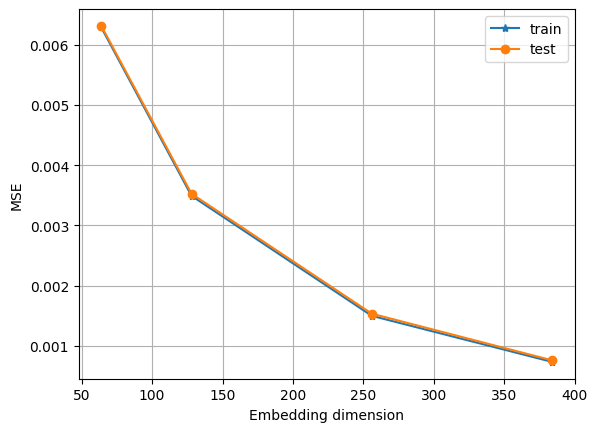

In [13]:
plt.plot(train_accuracies.keys(), train_accuracies.values(), marker='*', label='train')
plt.plot(test_accuracies.keys(), test_accuracies.values(), marker='o', label='test')
plt.grid()
plt.xlabel("Embedding dimension")
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [40]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

Training mse: 0.00440
Test mse: 0.00443


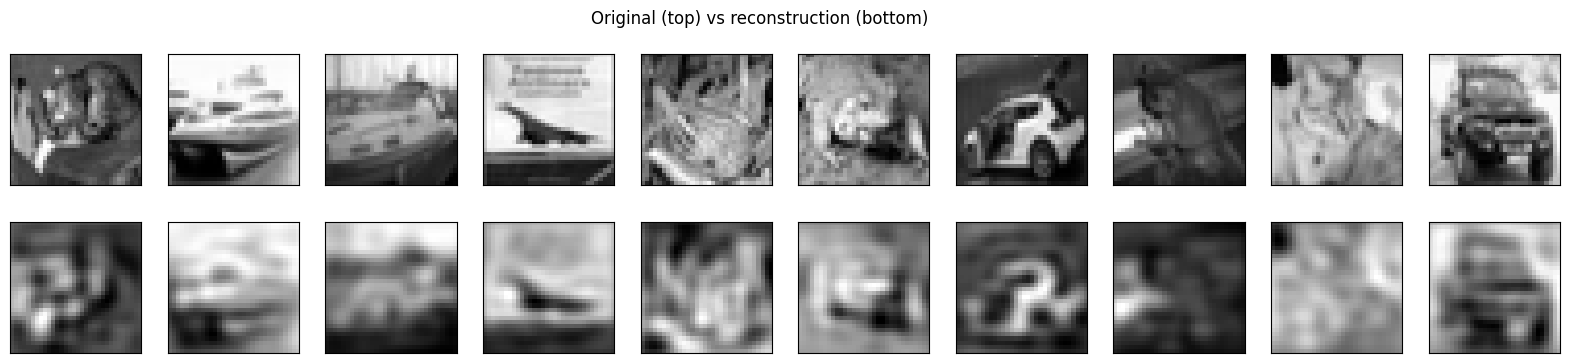

In [15]:
emb_dim =  100# [TO COMPLETE]
train_acc, test_acc, x_test_reco = SVD_Rec(emb_dim, True)
print("Training mse: %.5f" % ( train_acc))
print("Test mse: %.5f" % ( test_acc))
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below with reference to plot shown above.

`%STARTEXT`

**ANSWER**:
When changing ENCODING_DIM, the Mean Squared Error (MSE) for both the training and test datasets decreases. So it follows ENCODING_DIM can capture more information from the input data, leading to better reconstruction and hence lower MSE.

In the plot above I reconstruct from one component. As expected, the reconstructions are odd because only one component can capture only a small fraction of the variance in the data.

As the ENCODING_DIM increases, the reconstructions should become more and more similar to the original images. This is because more principal components can capture more of the variance in the data. However, after a certain point, increasing the ENCODING_DIM does not yeld better results.

From what we can observe our model struggles with pictures that do not have big highlights and difference in contrast, probably because Its harder for the model to understand the finer details.


`%ENDTEXT`

# Q2 [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. **[TO COMPLETE]** The `forward` method defines the forward pass of the Autoencoder. Your task is to complete the forward function and choose the appropriate activation function.

`%STARTCODE`

In [11]:
class Auto_Encoder(nn.Module):

  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}

    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))

      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer

    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))#[TO COMPLETE]
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))#[TO COMPLETE]
    if self.act_fun == 'linear': #[TO COMPLETE]
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

`%ENDCODE`

**[TO COMPLETE]** check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [18]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'linear'
lr = 0.005
epochs = 15 # Feel free to adjust this to speed up the training times. Nevertheless, esure the model is training long enough

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [19]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [20]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, print_step=1, tunning=False, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())

    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % print_step == 0 and not tunning:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [21]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.88192749 ---------------- Val_Acc: Val_Loss: 0.24441402
epoch: 2 -> Loss: 0.18690641 ---------------- Val_Acc: Val_Loss: 0.14553796
epoch: 3 -> Loss: 0.12051707 ---------------- Val_Acc: Val_Loss: 0.10085457
epoch: 4 -> Loss: 0.08740117 ---------------- Val_Acc: Val_Loss: 0.07678302
epoch: 5 -> Loss: 0.06781383 ---------------- Val_Acc: Val_Loss: 0.05887864
epoch: 6 -> Loss: 0.05352689 ---------------- Val_Acc: Val_Loss: 0.04835071
epoch: 7 -> Loss: 0.04365069 ---------------- Val_Acc: Val_Loss: 0.03966543
epoch: 8 -> Loss: 0.03616557 ---------------- Val_Acc: Val_Loss: 0.03358427
epoch: 9 -> Loss: 0.03071804 ---------------- Val_Acc: Val_Loss: 0.02898297
epoch: 10 -> Loss: 0.02730751 ---------------- Val_Acc: Val_Loss: 0.02626616
epoch: 11 -> Loss: 0.02380276 ---------------- Val_Acc: Val_Loss: 0.02266986
epoch: 12 -> Loss: 0.02094148 ---------------- Val_Acc: Val_Loss: 0.02024533
epoch: 13 -> Loss: 0.01894407 ---------------- Val_Acc: Val_Loss: 0.01837700
epoch: 1

In [27]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

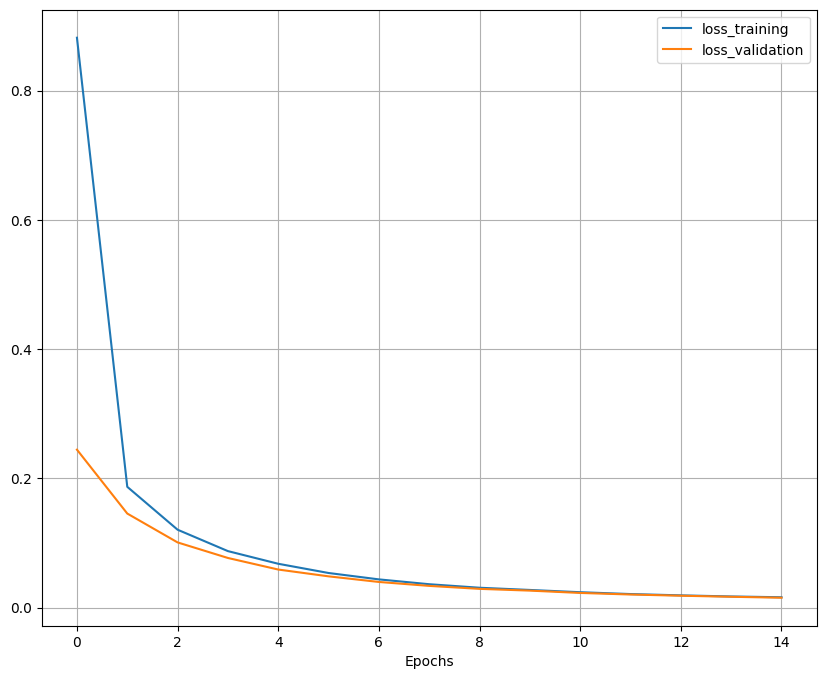

In [23]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [33]:
def test(model, dataloader_test=dataloader_test_AE, tunning=False, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  if not tunning:
    print(f"Test Loss: {loss_test:.8f}")
  else:
    return loss_test

In [25]:
test(Shallow_AE)

Test Loss: 0.01527324


In [26]:
train_mse = {}
test_mse = {}
epochs = 15 # just to test
for emb_dim in [16, 32, 64, 128, 256]:
    ENC_LAYERS = [emb_dim]
    Shallow_AE_Cand = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
    optimizer = torch.optim.Adam(Shallow_AE_Cand.parameters(), lr=lr)
    loss_train, _ = train(Shallow_AE_Cand, optimizer, dataloader_train_AE,
                          dataloader_val_AE, epochs, tunning=True)

    train_mse[emb_dim] = loss_train[-1]
    test_mse[emb_dim] = test(Shallow_AE_Cand, tunning=True).item()

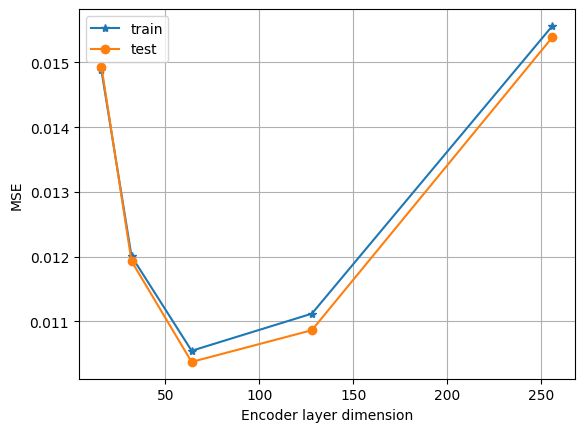

In [27]:
plt.plot(train_mse.keys(), train_mse.values(), marker='*', label='train')
plt.plot(test_mse.keys(), test_mse.values(), marker='o', label='test')
plt.grid()
plt.xlabel("Encoder layer dimension")
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [28]:
BEST_ENC_LAYERS = [128] # should be changed to the best one.
epochs = 30 # try with higher number than before
BEST_Shallow_AE = Auto_Encoder(IN_DIM, BEST_ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
optimizer = torch.optim.Adam(BEST_Shallow_AE.parameters(), lr=lr)
_, _ = train(BEST_Shallow_AE, optimizer, dataloader_train_AE, dataloader_val_AE, epochs)

epoch: 1 -> Loss: 0.46146944 ---------------- Val_Acc: Val_Loss: 0.13434790
epoch: 2 -> Loss: 0.10547163 ---------------- Val_Acc: Val_Loss: 0.07912692
epoch: 3 -> Loss: 0.06646041 ---------------- Val_Acc: Val_Loss: 0.05588993
epoch: 4 -> Loss: 0.04852869 ---------------- Val_Acc: Val_Loss: 0.04221967
epoch: 5 -> Loss: 0.03976208 ---------------- Val_Acc: Val_Loss: 0.03365727
epoch: 6 -> Loss: 0.03036184 ---------------- Val_Acc: Val_Loss: 0.02805443
epoch: 7 -> Loss: 0.02562227 ---------------- Val_Acc: Val_Loss: 0.02384406
epoch: 8 -> Loss: 0.02206839 ---------------- Val_Acc: Val_Loss: 0.02081153
epoch: 9 -> Loss: 0.01941359 ---------------- Val_Acc: Val_Loss: 0.01853203
epoch: 10 -> Loss: 0.01740844 ---------------- Val_Acc: Val_Loss: 0.01675938
epoch: 11 -> Loss: 0.01582398 ---------------- Val_Acc: Val_Loss: 0.01520644
epoch: 12 -> Loss: 0.01446363 ---------------- Val_Acc: Val_Loss: 0.01396935
epoch: 13 -> Loss: 0.01333743 ---------------- Val_Acc: Val_Loss: 0.01295307
epoch: 1

In [34]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [30]:
# encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)
encoded_imgs, decoded_imgs = apply_on_test(model=BEST_Shallow_AE, device=device)

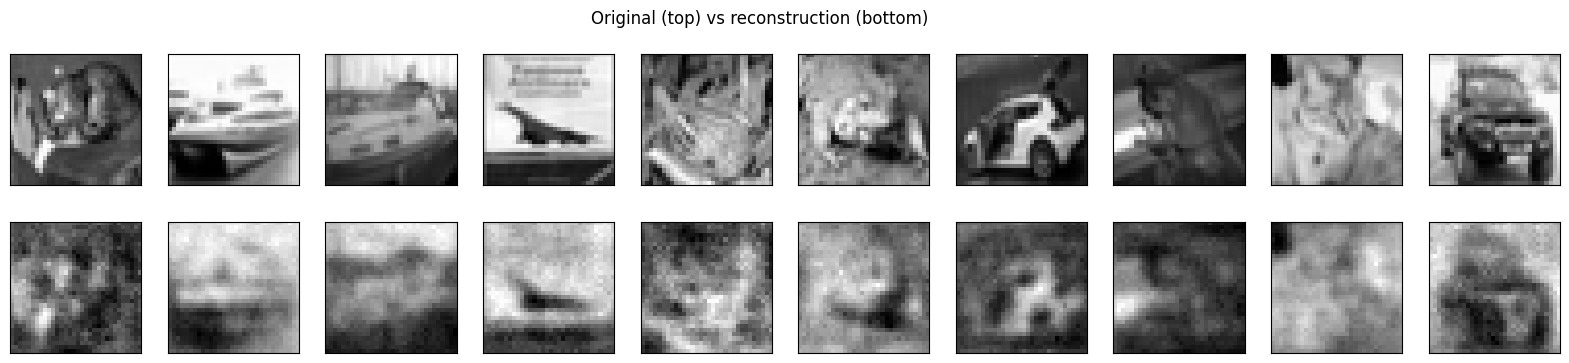

In [31]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:

`%STARTEXT`

# Q3 [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [36]:
# [TO COMPLETE]
# define model and training hyperparameters

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 50

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [33]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [34]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04431420 ---------------- Val_Acc: Val_Loss: 0.03107516
epoch: 2 -> Loss: 0.02726157 ---------------- Val_Acc: Val_Loss: 0.02363059
epoch: 3 -> Loss: 0.02172458 ---------------- Val_Acc: Val_Loss: 0.01967284
epoch: 4 -> Loss: 0.01882550 ---------------- Val_Acc: Val_Loss: 0.01722979
epoch: 5 -> Loss: 0.01710721 ---------------- Val_Acc: Val_Loss: 0.01710354
epoch: 6 -> Loss: 0.01651396 ---------------- Val_Acc: Val_Loss: 0.01567688
epoch: 7 -> Loss: 0.01588171 ---------------- Val_Acc: Val_Loss: 0.01567975
epoch: 8 -> Loss: 0.01560110 ---------------- Val_Acc: Val_Loss: 0.01500569
epoch: 9 -> Loss: 0.01507275 ---------------- Val_Acc: Val_Loss: 0.01495521
epoch: 10 -> Loss: 0.01472610 ---------------- Val_Acc: Val_Loss: 0.01471357
epoch: 11 -> Loss: 0.01434076 ---------------- Val_Acc: Val_Loss: 0.01423271
epoch: 12 -> Loss: 0.01403852 ---------------- Val_Acc: Val_Loss: 0.01393830
epoch: 13 -> Loss: 0.01366926 ---------------- Val_Acc: Val_Loss: 0.01353976
epoch: 1

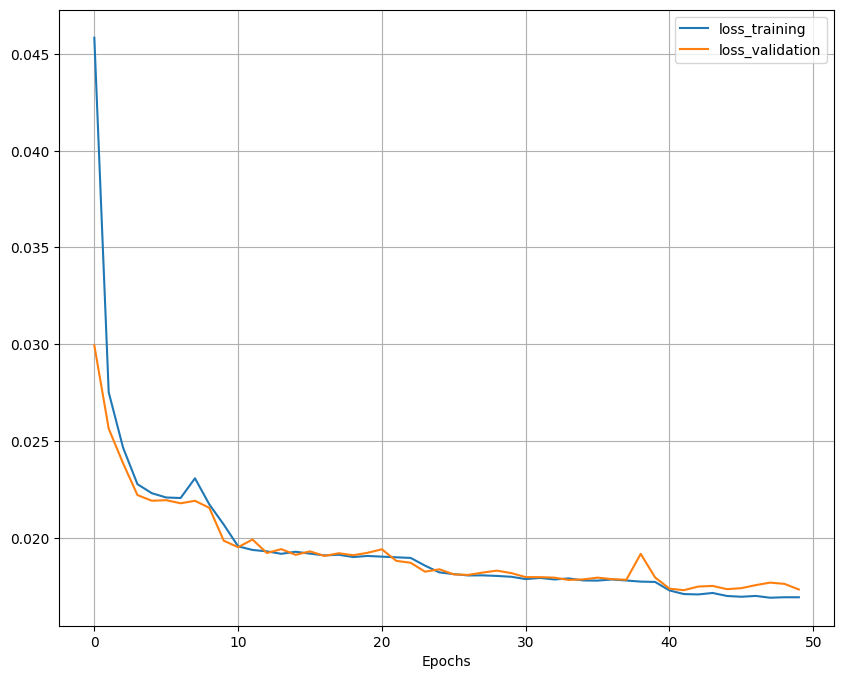

In [28]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [35]:
test(Shallow_non_AE)

NameError: name 'Shallow_non_AE' is not defined

In [30]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

NameError: name 'apply_on_test' is not defined

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**: ReLu failed, by reconstructing only gradients and not any recognizable pattern, after some research I believe to have encontered a 'dying ReLu' problem, where there is a big gradient that goes through a ReLu neuron and outputs 0 for all sequent inputs. After testing a Leaky ReLu the reconstructed pictures stll retained some fuzzisness, but retained basic information such as the shape o the vehicles and still struggled with low contrast images. After augmenting the number of iterations the model seems to improve more and more.

`%ENDTEXT`

# Q4 [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [71]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512, 256, 128, 64, 32]
DEC_LAYERS = [32, 64, 128, 256, 512]
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 20
DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
│    └─Linear: 2-2                       [512, 256]                131,328
│    └─Linear: 2-3                       [512, 128]                32,896
│    └─Linear: 2-4                       [512, 64]                 8,256
│    └─Linear: 2-5                       [512, 32]                 2,080
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-6                       [512, 32]                 1,056
│    └─Linear: 2-7                       [512, 64]                 2,112
│    └─Linear: 2-8                       [512, 128]                8,320
│    └─Linear: 2-9                       [512, 256]                33,024
│    └─Linear: 2-10                      [512, 512] 

In [72]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [73]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04193314 ---------------- Val_Acc: Val_Loss: 0.03175550
epoch: 2 -> Loss: 0.03193628 ---------------- Val_Acc: Val_Loss: 0.03146455
epoch: 3 -> Loss: 0.03181050 ---------------- Val_Acc: Val_Loss: 0.03156860
epoch: 4 -> Loss: 0.03401507 ---------------- Val_Acc: Val_Loss: 0.03192159
epoch: 5 -> Loss: 0.03123935 ---------------- Val_Acc: Val_Loss: 0.02795338
epoch: 6 -> Loss: 0.02767692 ---------------- Val_Acc: Val_Loss: 0.02746513
epoch: 7 -> Loss: 0.02746781 ---------------- Val_Acc: Val_Loss: 0.02737355
epoch: 8 -> Loss: 0.02749585 ---------------- Val_Acc: Val_Loss: 0.02753504
epoch: 9 -> Loss: 0.02740143 ---------------- Val_Acc: Val_Loss: 0.02725116
epoch: 10 -> Loss: 0.02738804 ---------------- Val_Acc: Val_Loss: 0.02733354
epoch: 11 -> Loss: 0.02742082 ---------------- Val_Acc: Val_Loss: 0.02743891
epoch: 12 -> Loss: 0.02734735 ---------------- Val_Acc: Val_Loss: 0.02725635
epoch: 13 -> Loss: 0.02743072 ---------------- Val_Acc: Val_Loss: 0.02738951
epoch: 1

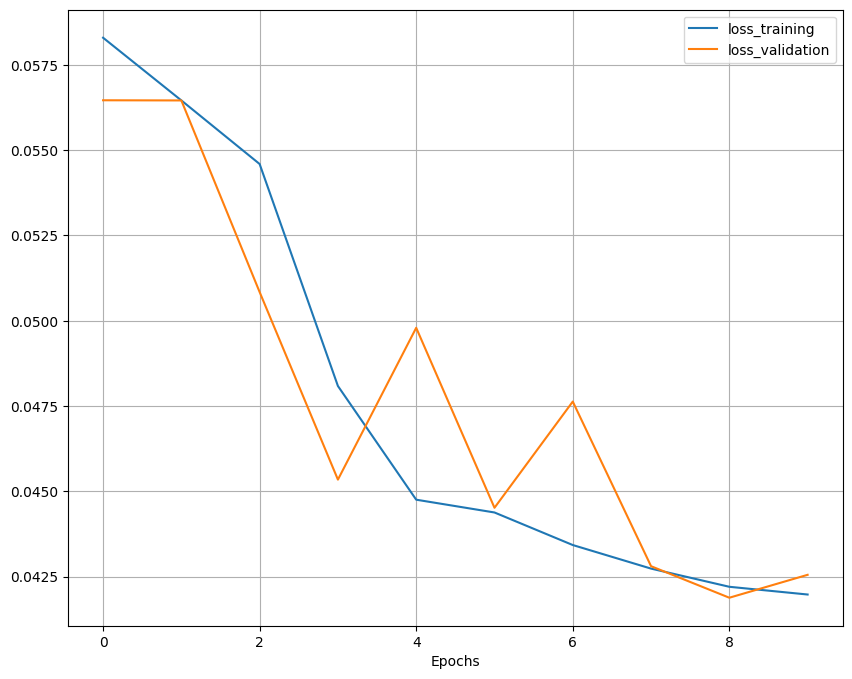

In [60]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [1]:
test(DEEP_non_AE)

NameError: name 'test' is not defined

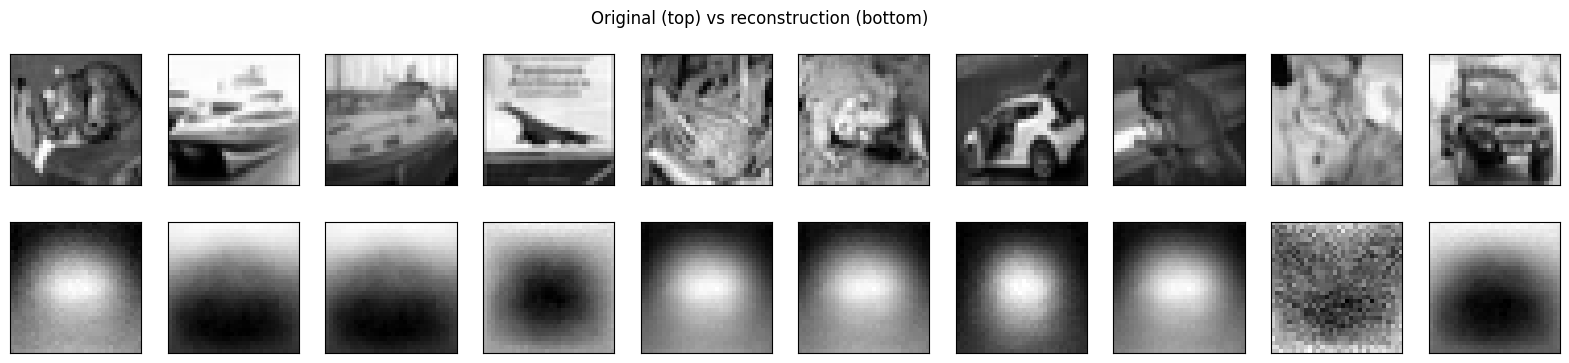

In [62]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**:
First try
ENC_LAYERS = [512, 256, 128, 64, 32]
DEC_LAYERS = [64, 128, 256, 512]
ACT_FUN = 'leaky_relu'
Test Loss: 0.02147425
bad, blobby mess and unstable learning curve

ENC_LAYERS = [512, 256, 128]
DEC_LAYERS = [128, 256, 512]
ACT_FUN = 'leaky_relu'
more defined but soft
Test Loss: 0.01409393

ENC_LAYERS = [256, 128, 64]
DEC_LAYERS = [54, 128, 256]
ACT_FUN = 'leaky_relu'
ACT_FUN = 'leaky_relu'
more defined but soft
Test Loss: 0.01909393

Test Loss: 0.01747170
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512, 64]
DEC_LAYERS = [64, 128, 512]
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 50
just spots

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512, 64, 32]
DEC_LAYERS = [32,128]
ACT_FUN = 'leaky_relu'
Does NOT retain info at all

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [1024, 512, 256]
DEC_LAYERS = [256 , 512]
ACT_FUN = 'leaky_relu'
lr = 0.005
epochs = 50
not able to improve at all

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512, 256]
DEC_LAYERS = [256 , 512, 1024]
ACT_FUN = 'leaky_relu'
lr = 0.005
not able to improve at all

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512, 256]
DEC_LAYERS = [64, 256 , 512]
ACT_FUN = 'leaky_relu'
just faint shapes

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512, 256, 128]
DEC_LAYERS = [128, 256, 512]
ACT_FUN = 'tanh'
lr = 0.005
not improving at all


`%ENDTEXT`

# Q5 [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values, and write a short report of your findings below. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$.

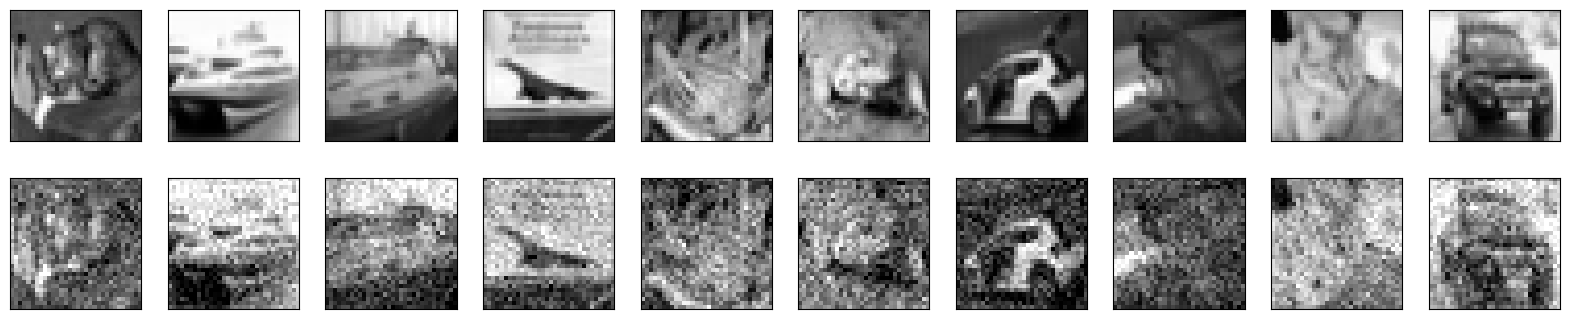

In [63]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [64]:
# [TO COMPLETE]
# define model and training hyperparameters


SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
│    └─Linear: 2-2                       [512, 256]                131,328
│    └─Linear: 2-3                       [512, 128]                32,896
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 128]                16,512
│    └─Linear: 2-5                       [512, 256]                33,024
│    └─Linear: 2-6                       [512, 512]                131,584
│    └─Linear: 2-7                       [512, 1024]               525,312
Total params: 1,395,456
Trainable params: 1,395,456
Non-trainable params: 0
Total mult-adds (M): 714.47
Input size (MB): 2.10
Forward/backward pass size (MB): 11.53
Params size (MB): 5.58
Estim

In [65]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [66]:
start = timer()
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising= True)

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.05827586 ---------------- Val_Acc: Val_Loss: 0.05645463
epoch: 2 -> Loss: 0.05645954 ---------------- Val_Acc: Val_Loss: 0.05645865


KeyboardInterrupt: 

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`

**ANSWER**:

`%ENDTEXT`